In [1]:
from collections import Counter, defaultdict
import glob
import itertools
import json
import matplotlib.pyplot as plt
plt.style.use('../peptidome.mplstyle')

import numpy as np
import pandas as pd
from scipy.stats import sem


import sys
sys.path.append('..')

from lib import *
from lib.maxent import *


In [2]:
def compute_pc(arr):
    N = arr.shape[0]
    _, counts = np.unique(arr, return_counts=True,axis=0)
    return np.sum(counts * (counts - 1)) / (N * (N - 1))

In [3]:
arr =  np.random.choice(np.arange(0, 10, 1), size=(50000,3))

In [4]:
compute_pc(arr)

np.float64(0.0009986663733274666)

In [5]:
calc_coincidence_prob(arr)

np.float64(0.0009986464)

## Original Samples from pre-print

In [33]:
data = {}

In [34]:
proteome = 'Human'
models = ['independent', 'ncov', 'nskew', 'nskewfcov']
k = 9

original_sampler = {
    'pc' : {},
    'S': {},
    'N': {},
    'energies': {}
}


for model in models:
    print(f'model: {model}')
    energy = make_energy(np.load(f'../maxent/data/{proteome}_{model}_k{k}_params.npz'))
    F = float(pd.read_csv(f'../maxent/data/{proteome}_{model}_k{k}_entropy.csv',header=None, index_col=0).loc['F'].values[0])
    
    loglikelihood  = lambda seq: -energy(seq) + F
    
    matrix = load_matrix(f'data/{proteome}_{model}_k{k}_matrix.csv.gz')

    original_sampler['N'][model] = matrix.shape[0]
    coincidence_empirical = calc_coincidence_prob(matrix)
    original_sampler['pc'][model] = compute_pc(matrix)
    logp = np.array([loglikelihood(row) for row in matrix])

    energies = [energy(x) for x in matrix]
    original_sampler['energies'][model] = energies
    original_sampler['S'][model] = np.mean(np.array(energies)) - F    

data['original_sample'] = original_sampler

model: independent
model: ncov
model: nskew
model: nskewfcov


## Load New Samples and compute stats

In [35]:
# Focus on human for now for comparisons
proteome = 'Human'
models = ['independent', 'ncov', 'nskew', 'nskewfcov']
# NSTEPS = ["5418757", "1e7", "5e7"]
NSTEPS = ["5418757", "1e7"]
thinning = ["9", "20", "50"]
k=9

for n in NSTEPS:
    for t in thinning:
        sampler = {
            'pc' : {},
            'S': {},
            'N': {},
            'energies': {},
        }
        for model in models:
            print(f'model: {model}')
            energy = make_energy(np.load(f'data/{proteome}_{model}_k{k}_params.npz'))
            F = float(pd.read_csv(f"data/mcmc_thermo/{proteome}_{model}_{n}_{t}_entropy.csv",header=None, index_col=0).loc['F'].values[0])
            
            loglikelihood  = lambda seq: -energy(seq) + F
            
            matrix = load_matrix(f"data/mcmc_thermo/{proteome}_{model}_{n}_{t}_matrix.csv.gz")
        
            sampler['N'][model] = matrix.shape[0]
            coincidence_empirical = calc_coincidence_prob(matrix)
            sampler['pc'][model] = compute_pc(matrix)
            logp = np.array([loglikelihood(row) for row in matrix])
        
            energies = [energy(x) for x in matrix]
            sampler['energies'][model] = energies
            sampler['S'][model] = np.mean(np.array(energies)) - F    

        data[f"Human_{n}_{t}"] = sampler


model: independent
model: ncov
model: nskew
model: nskewfcov
model: independent
model: ncov
model: nskew
model: nskewfcov
model: independent
model: ncov
model: nskew
model: nskewfcov
model: independent
model: ncov
model: nskew
model: nskewfcov
model: independent
model: ncov
model: nskew
model: nskewfcov
model: independent
model: ncov
model: nskew
model: nskewfcov


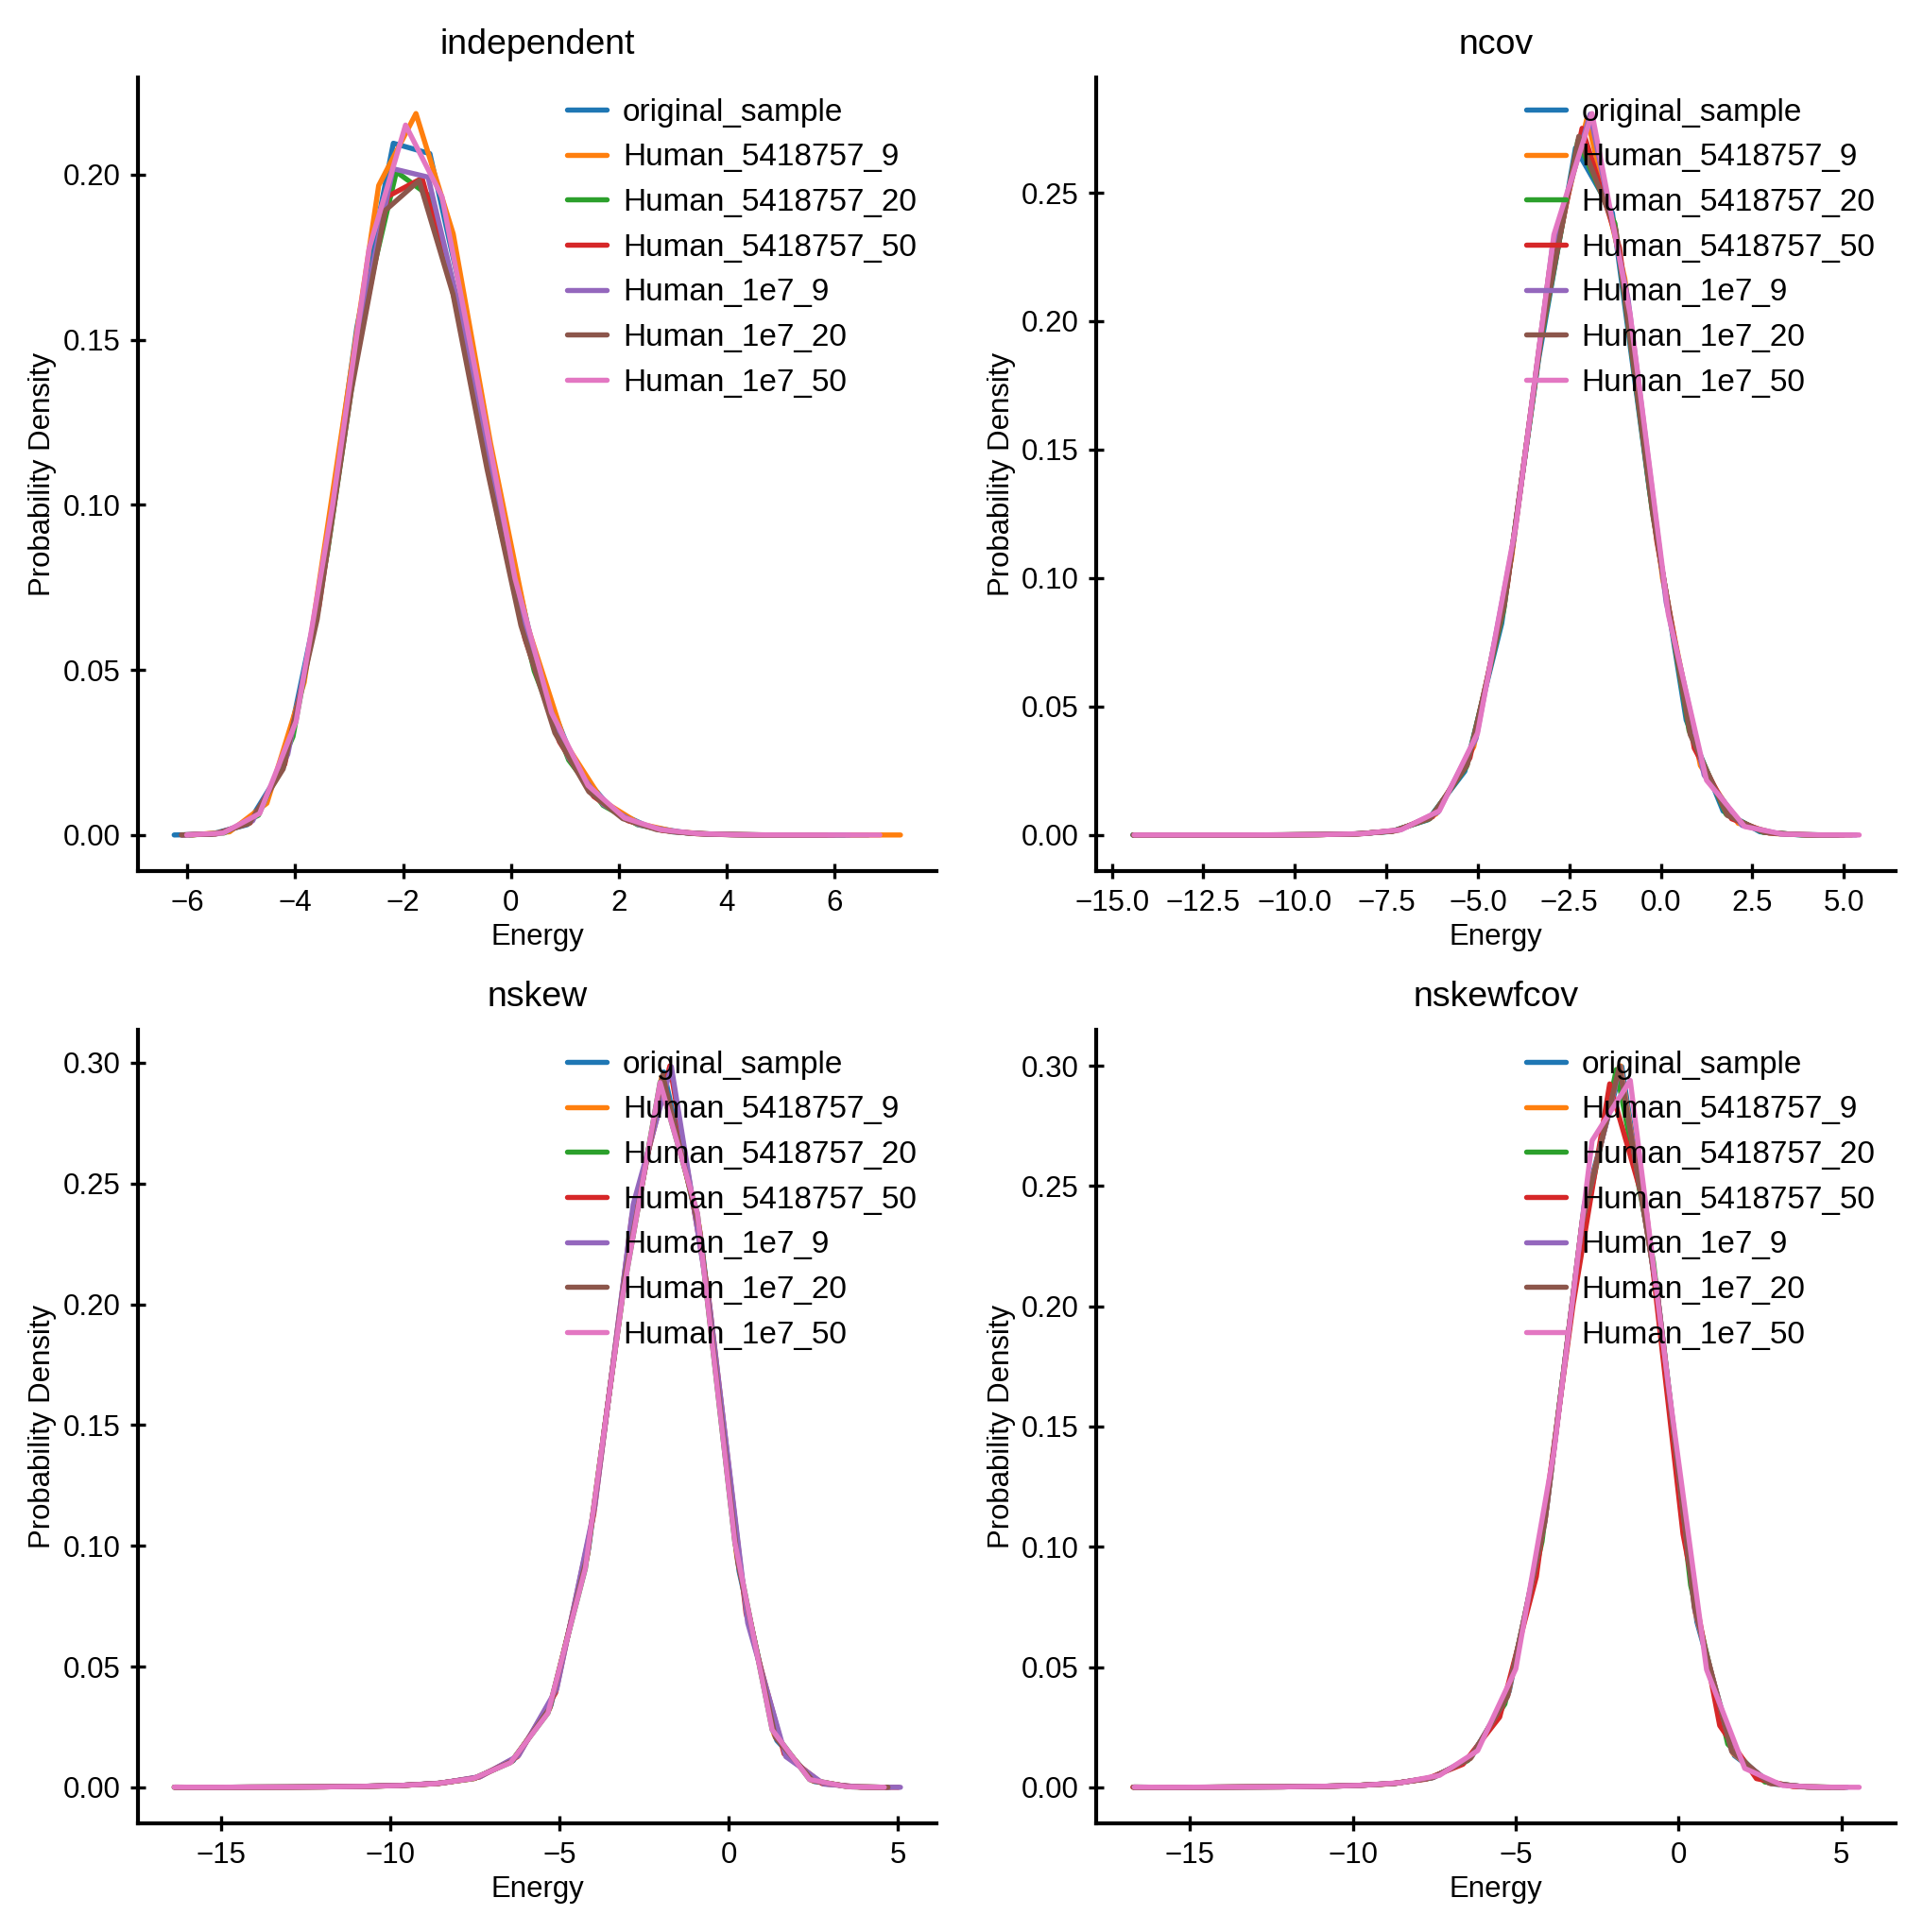

In [37]:
plt.figure(figsize=(8,8))
for i,model in enumerate(models):
    
    plt.subplot(2,2,i+1)
    for j, sampler in enumerate(data):
        count, bins_count = np.histogram(data[sampler]['energies'][model],bins=20)
        pdf = count / sum(count)
        plt.plot(bins_count[1:], pdf, label=sampler)
        plt.xlabel('Energy')
        plt.title(model)
        plt.ylabel('Probability Density')  
        plt.legend(loc='upper right',fontsize=8)

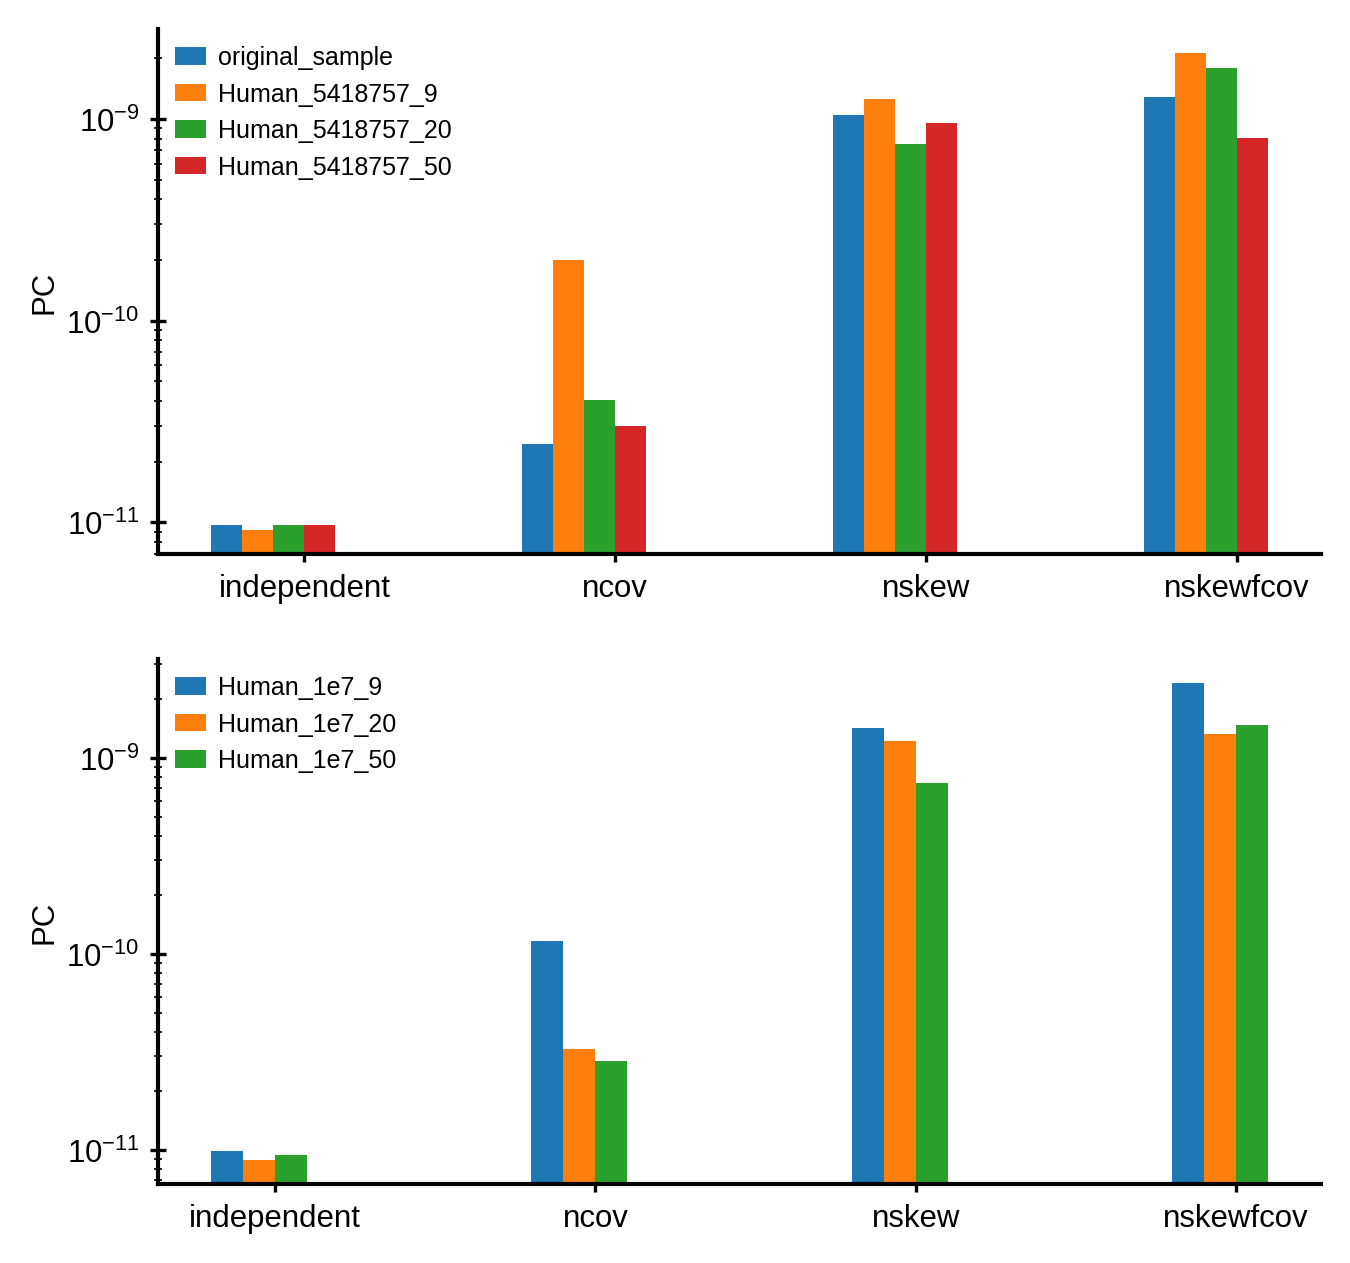

In [23]:
plt.figure(figsize=(5,5))

count = 0
for j, sampler in enumerate(data):

    if j % 4 == 0:
        count += 1
        plt.subplot(2,1,count)
        

    bar_data = [data[sampler]['pc'][model] for model in models]
    
    N = len(bar_data)
    ind = np.arange(N)
    width = 0.1  

    ind = ind + j*width
    plt.bar(ind + width, bar_data, width ,label=sampler)

    plt.yscale('log')

    plt.ylabel('PC')
    plt.xticks(ind + width / 2, models)
    plt.legend(fontsize=6)

plt.show()

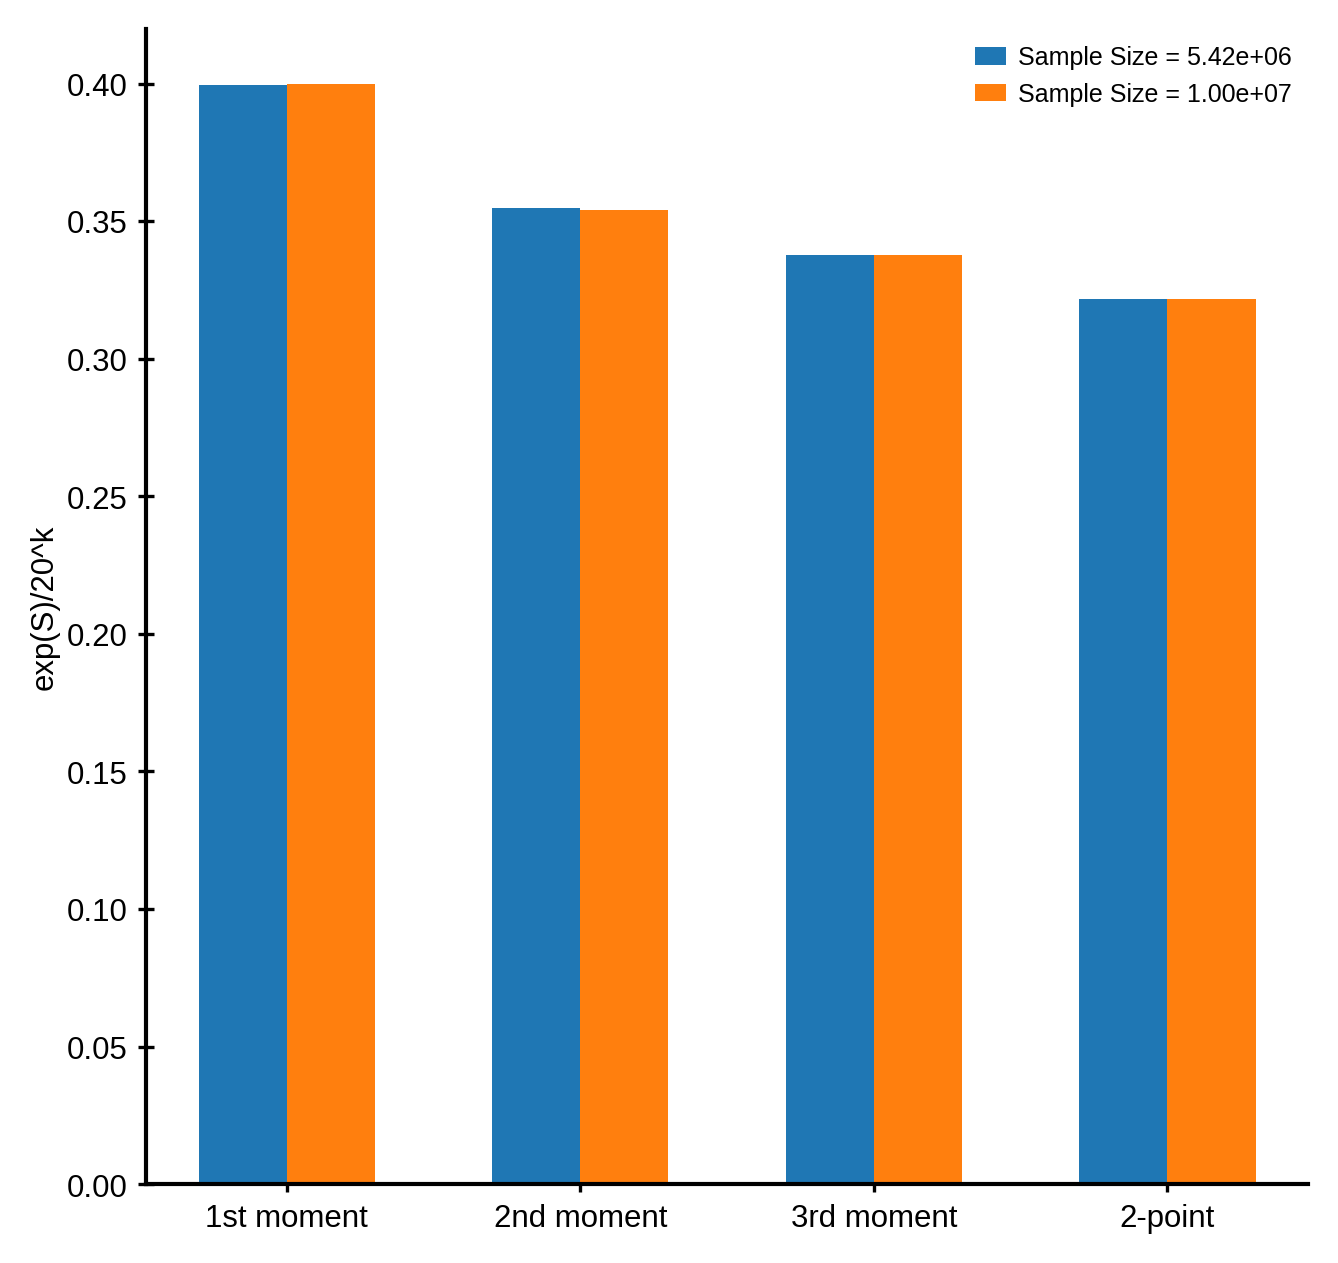

In [108]:
plt.figure(figsize=(5,5))

model_mapper = {
    "independent": "1st moment",
    "ncov": "2nd moment",
    "nskew": "3rd moment",
    "nskewfcov": "2-point"
}


small_sample = data["Human_5418757_9"]
large_sample = data["Human_1e7_9"]


#     if j % 4 == 0:
#         count += 1
#         plt.subplot(2,1,count)
        

small_bar_data = [np.exp(small_sample['S'][model])/(20**9) for model in models]
large_bar_data = [np.exp(large_sample['S'][model])/(20**9) for model in models]

    
N = len(small_bar_data)
ind = np.arange(N)
width = 0.3
sn = '{:.2e}'.format(5418757)
ln = '{:.2e}'.format(1e7)
plt.bar(ind, small_bar_data, width ,label=f"Sample Size = {sn}")
plt.bar(ind+width, large_bar_data, width ,label=f"Sample Size = {ln}")

        

plt.ylabel('exp(S)/20^k')
plt.xticks(ind + width / 2, model_mapper.values())
plt.legend(fontsize=6, loc='upper right')

plt.savefig('plots/shannon_sample_size_plots.png')

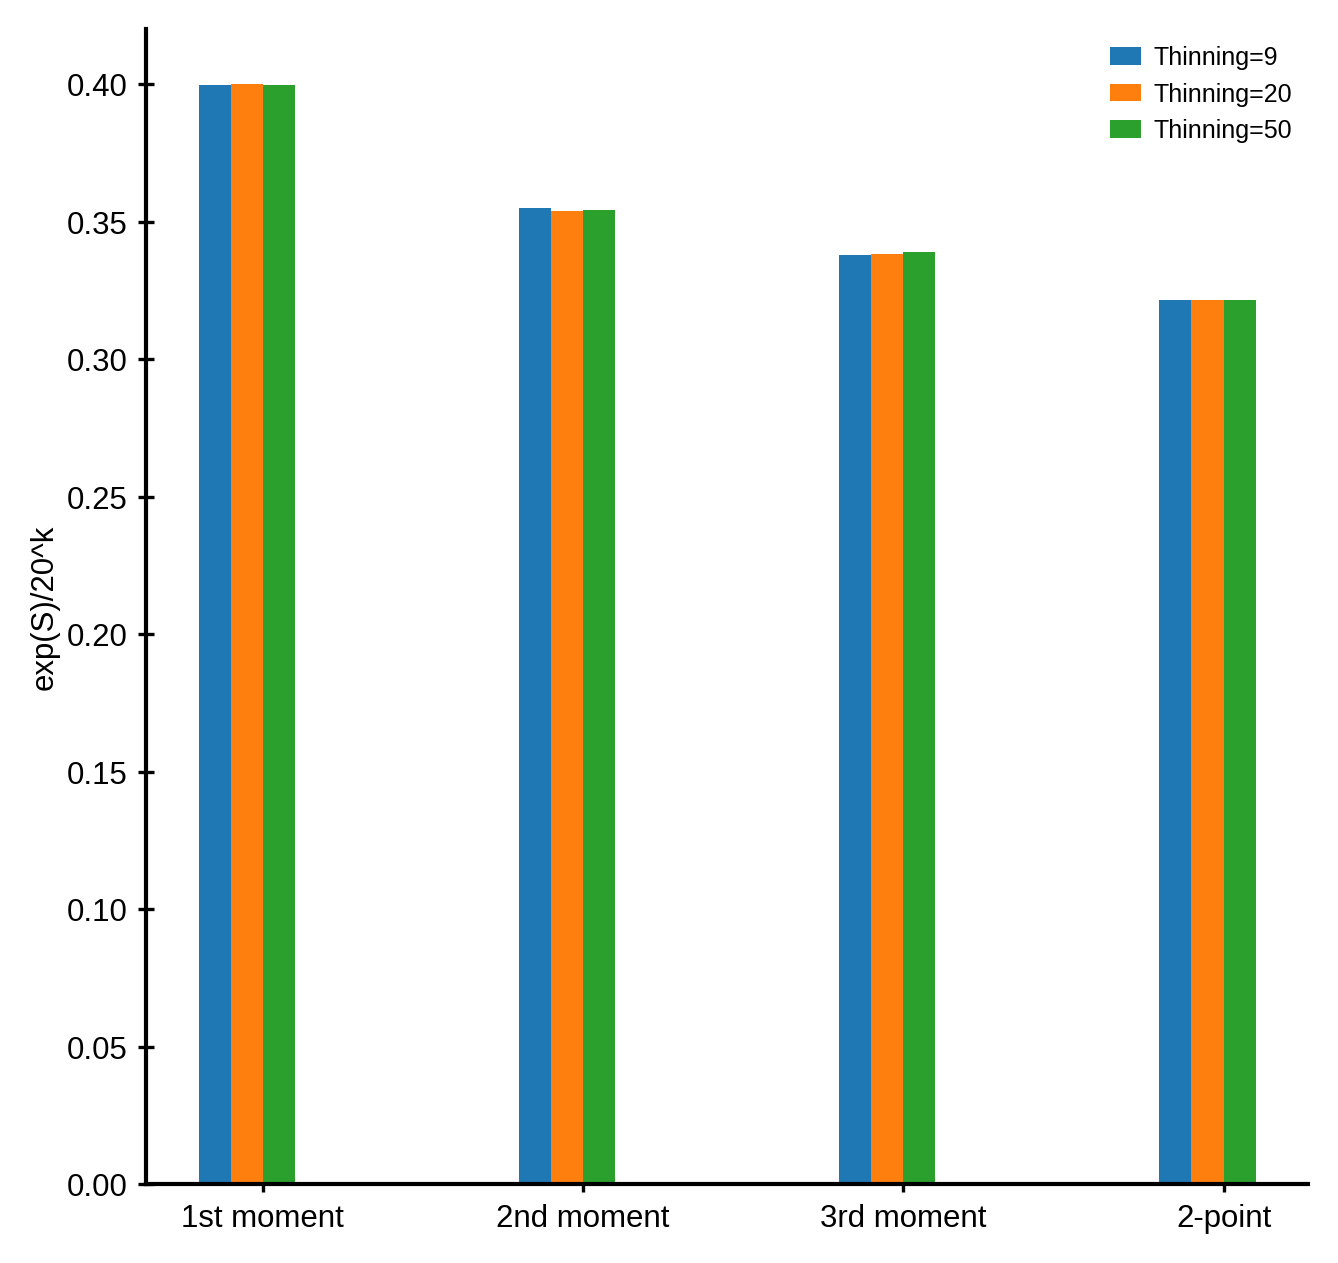

In [107]:
plt.figure(figsize=(5,5))

model_mapper = {
    "independent": "1st moment",
    "ncov": "2nd moment",
    "nskew": "3rd moment",
    "nskewfcov": "2-point"
}


count = 0
for j, sampler in enumerate(data):
    
    if not sampler.startswith('Human_5'):
        continue

    if j % 4 == 0:
        count += 1
        plt.subplot(2,1,count)
        

    bar_data = [np.exp(data[sampler]['S'][model])/(20**9) for model in models]
    
    N = len(bar_data)
    ind = np.arange(N)
    width = 0.1  

    ind = ind + j*width
    plt.bar(ind + width, bar_data, width ,label=f"Thinning={sampler.split('_')[-1]}")

    plt.ylabel('exp(S)/20^k')
    plt.xticks(ind + width / 2, model_mapper.values())
    plt.legend(fontsize=6, loc='upper right')

plt.savefig('plots/shannon_thinning_plots.png')

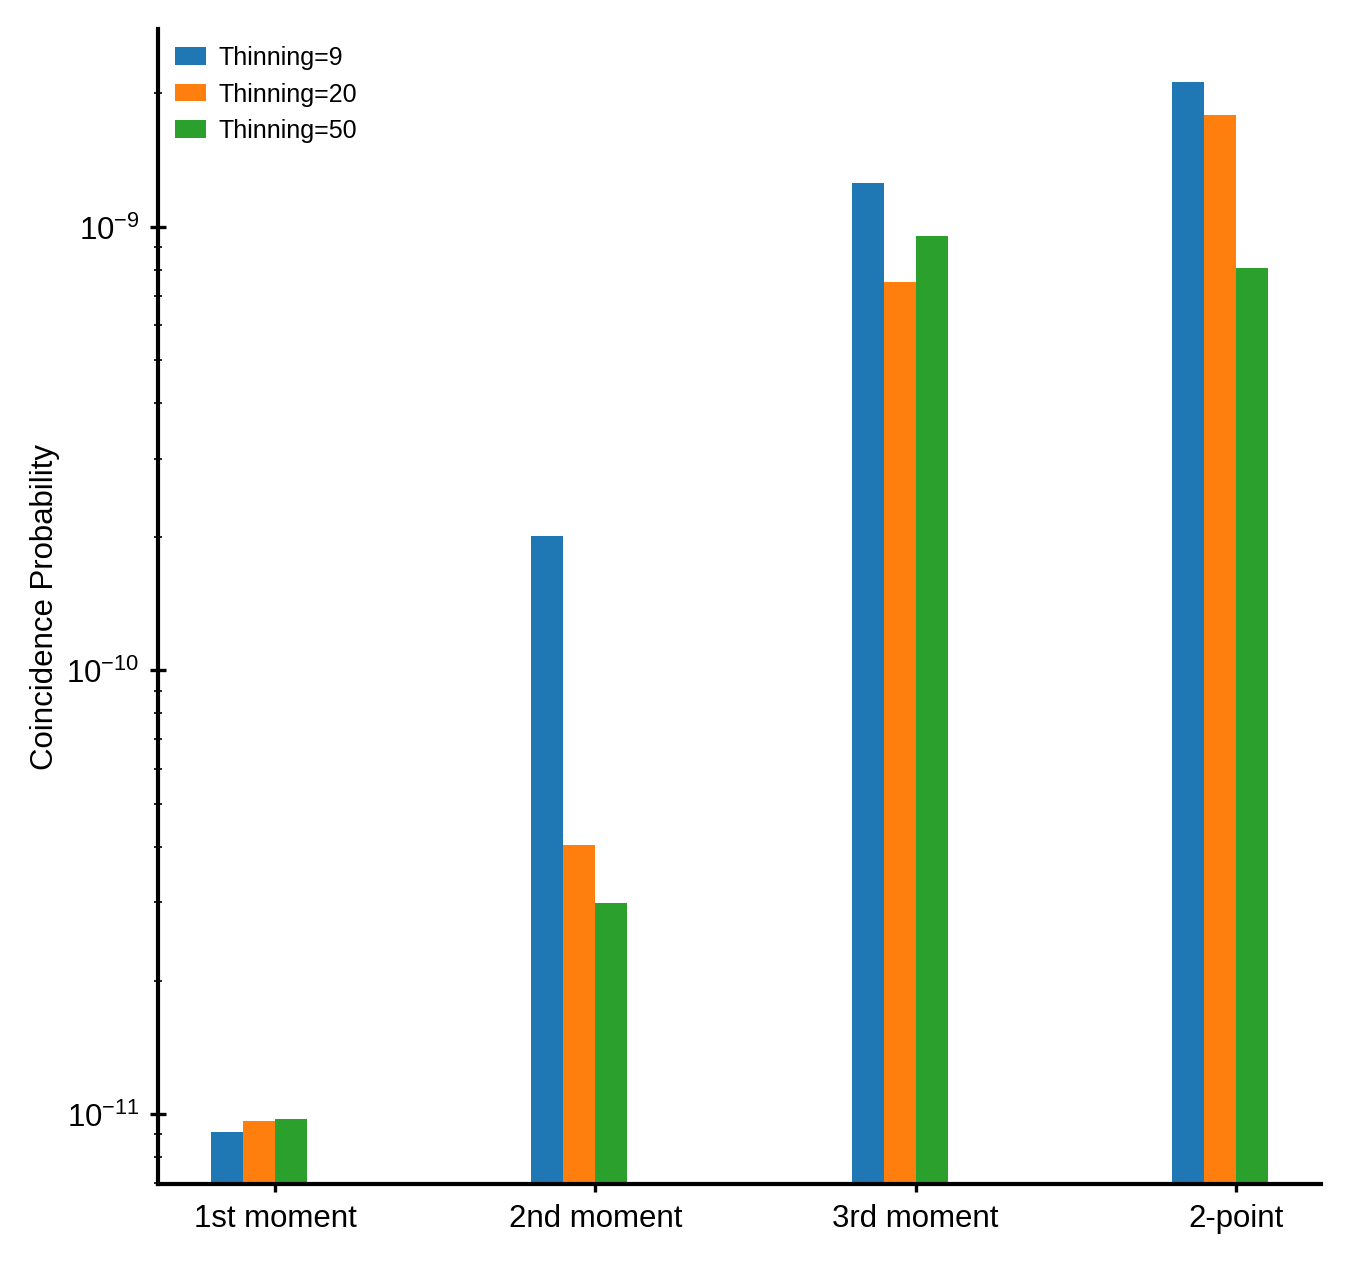

In [106]:
plt.figure(figsize=(5,5))

model_mapper = {
    "independent": "1st moment",
    "ncov": "2nd moment",
    "nskew": "3rd moment",
    "nskewfcov": "2-point"
}


count = 0
for j, sampler in enumerate(data):
    
    if not sampler.startswith('Human_5'):
        continue

    if j % 4 == 0:
        count += 1
        plt.subplot(2,1,count)
        

    bar_data = [data[sampler]['pc'][model] for model in models]
    
    N = len(bar_data)
    ind = np.arange(N)
    width = 0.1  

    ind = ind + j*width
    plt.bar(ind + width, bar_data, width ,label=f"Thinning={sampler.split('_')[-1]}")

    plt.ylabel('Coincidence Probability')
    plt.yscale('log')
    plt.xticks(ind + width / 2, model_mapper.values())
    plt.legend(fontsize=6, loc='upper left')

plt.savefig('plots/coincidence_thinning_plots.png')

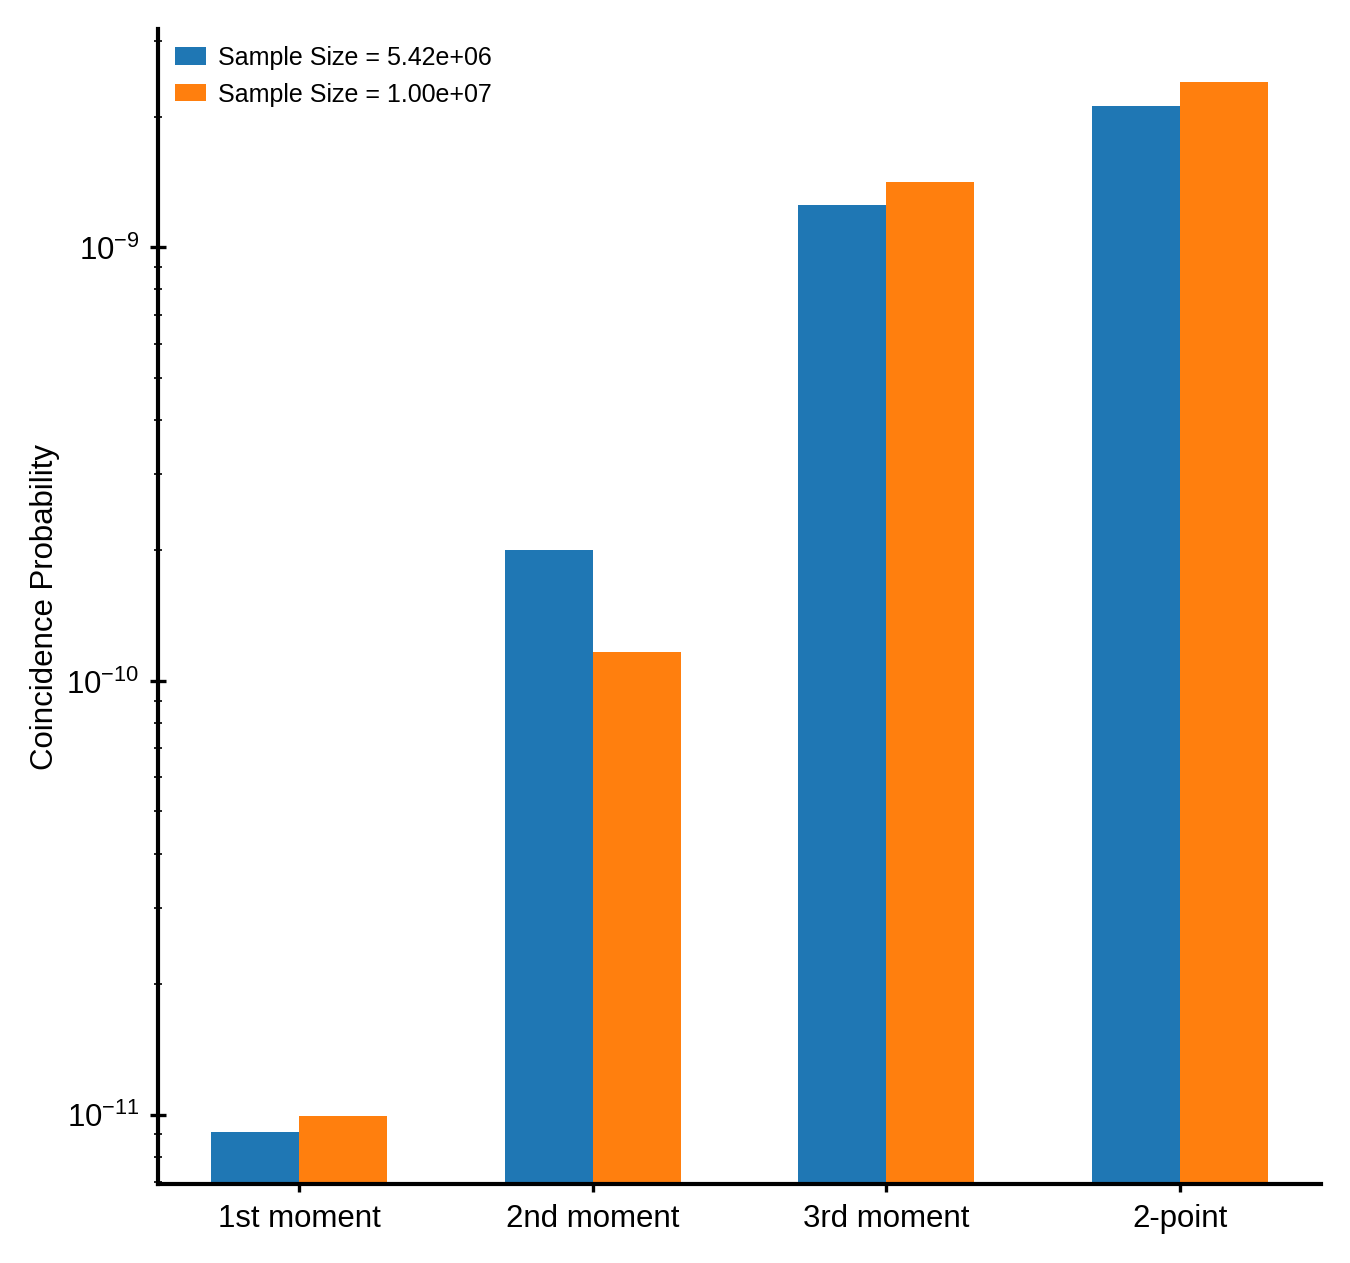

In [105]:
plt.figure(figsize=(5,5))

model_mapper = {
    "independent": "1st moment",
    "ncov": "2nd moment",
    "nskew": "3rd moment",
    "nskewfcov": "2-point"
}


small_sample = data["Human_5418757_9"]
large_sample = data["Human_1e7_9"]


#     if j % 4 == 0:
#         count += 1
#         plt.subplot(2,1,count)
        

small_bar_data = [small_sample['pc'][model] for model in models]
large_bar_data = [large_sample['pc'][model] for model in models]

    
N = len(small_bar_data)
ind = np.arange(N)
width = 0.3
sn = '{:.2e}'.format(5418757)
ln = '{:.2e}'.format(1e7)
plt.bar(ind, small_bar_data, width ,label=f"Sample Size = {sn}")
plt.bar(ind+width, large_bar_data, width ,label=f"Sample Size = {ln}")

        


plt.ylabel('Coincidence Probability')
plt.yscale('log')
plt.xticks(ind + width / 2, model_mapper.values())
plt.legend(fontsize=6, loc='upper left')

plt.savefig('plots/coincidence_sample_size_plots.png')

In [32]:
s_data_large

{'independent': {9: 26.04464636074318,
  10: 26.04508911581152,
  20: 26.04471050467383,
  30: 26.043750313452538,
  40: 26.044595543896893,
  50: 26.044352380301454,
  60: 26.044667124290566,
  70: 26.044387396505872,
  80: 26.04434216052116,
  90: 26.04377905216946,
  100: nan},
 'ncov': {9: 25.92314222638474,
  10: 25.924776592187335,
  20: 25.923606040360944,
  30: 25.923978333879678,
  40: 25.923722471959216,
  50: 25.924669411702382,
  60: 25.923623440720334,
  70: 25.923400900312917,
  80: 25.923302913150412,
  90: 25.923578692544915,
  100: nan},
 'nskew': {9: 25.87577621455706,
  10: 25.87779441330105,
  20: 25.877119047494727,
  30: 25.878017766390325,
  40: 25.87654569719601,
  50: 25.87686976378382,
  60: 25.877727314715944,
  70: 25.877889087110923,
  80: 25.877278378156237,
  90: 25.87683053302079,
  100: nan},
 'nskewfcov': {9: 25.82750892341442,
  10: 25.827494014210355,
  20: 25.82793948015174,
  30: 25.826997477568625,
  40: 25.826238244423802,
  50: 25.82631333882231

In [7]:
thinning_data = {}

In [33]:
# Additional Thinning Analysis
proteome = 'Human'
models = ['independent', 'ncov', 'nskew', 'nskewfcov']
NSTEPS = ["5418757","1e7"]
thinning = ["9", "10", "20","30","40","50","60","70","80","90","100"]
thinning=["100"]
k=9



for n in NSTEPS:
    for t in thinning:
        sampler = {
            'pc' : {},
            'S': {},
            'N': {},
            'energies': {},
        }
        for model in models:
            print(f'model: {model}')
            
            if not os.path.exists(f"data/mcmc_thermo/{proteome}_{model}_{n}_{t}_entropy.csv"):
                print(f"data/mcmc_thermo/{proteome}_{model}_{n}_{t}_entropy.csv")
                continue
                
            energy = make_energy(np.load(f'data/{proteome}_{model}_k{k}_params.npz'))
            
            F = float(pd.read_csv(f"data/mcmc_thermo/{proteome}_{model}_{n}_{t}_entropy.csv",header=None, index_col=0).loc['F'].values[0])
            
            loglikelihood  = lambda seq: -energy(seq) + F
            
            matrix = load_matrix(f"data/mcmc_thermo/{proteome}_{model}_{n}_{t}_matrix.csv.gz")
        
            sampler['N'][model] = matrix.shape[0]
            coincidence_empirical = calc_coincidence_prob(matrix)
            sampler['pc'][model] = compute_pc(matrix)
            logp = np.array([loglikelihood(row) for row in matrix])
        
            energies = [energy(x) for x in matrix]
            sampler['energies'][model] = energies
            sampler['S'][model] = np.mean(np.array(energies)) - F    

        thinning_data[f"Human_{n}_{t}"] = sampler
        
        

model: independent
model: ncov
model: nskew
model: nskewfcov
model: independent
model: ncov
model: nskew
model: nskewfcov


In [37]:
with open('data/human_model_thinning_analysis_2.json', 'w') as fp:
    json.dump(thinning_data, fp)

In [2]:
with open('data/human_model_thinning_analysis_2.json', 'r') as fp:
    thinning_data = json.load(fp)

In [3]:
models = ['independent', 'ncov', 'nskew', 'nskewfcov']
s_data_small = {}
pc_data_small = {}
s_data_large = {}
pc_data_large = {}
for model in models:
    s_data_small[model] = {}
    pc_data_small[model] = {}
    s_data_large[model] = {}
    pc_data_large[model] = {}
for params, sampler in thinning_data.items():
    t_param = int(params.split("_")[-1])
    size = params.split("_")[1]
    s_dict = s_data_small if size == "5418757" else s_data_large
    pc_dict = pc_data_small if size == "5418757" else pc_data_large
    for model in models:
        try:
            s_dict[model][t_param]= sampler['S'][model]
            pc_dict[model][t_param]= sampler['pc'][model]
        except KeyError:
            s_dict[model][t_param] = np.nan 
            pc_dict[model][t_param]=np.nan
        

In [4]:
model_mapper = {
    "independent": "1st moment",
    "ncov": "2nd moment",
    "nskew": "3rd moment",
    "nskewfcov": "2-point"
}
k=9

color_mapper = {
    "independent": "blue",
    "ncov": "orange",
    "nskew": "green",
    "nskewfcov": "red"
}

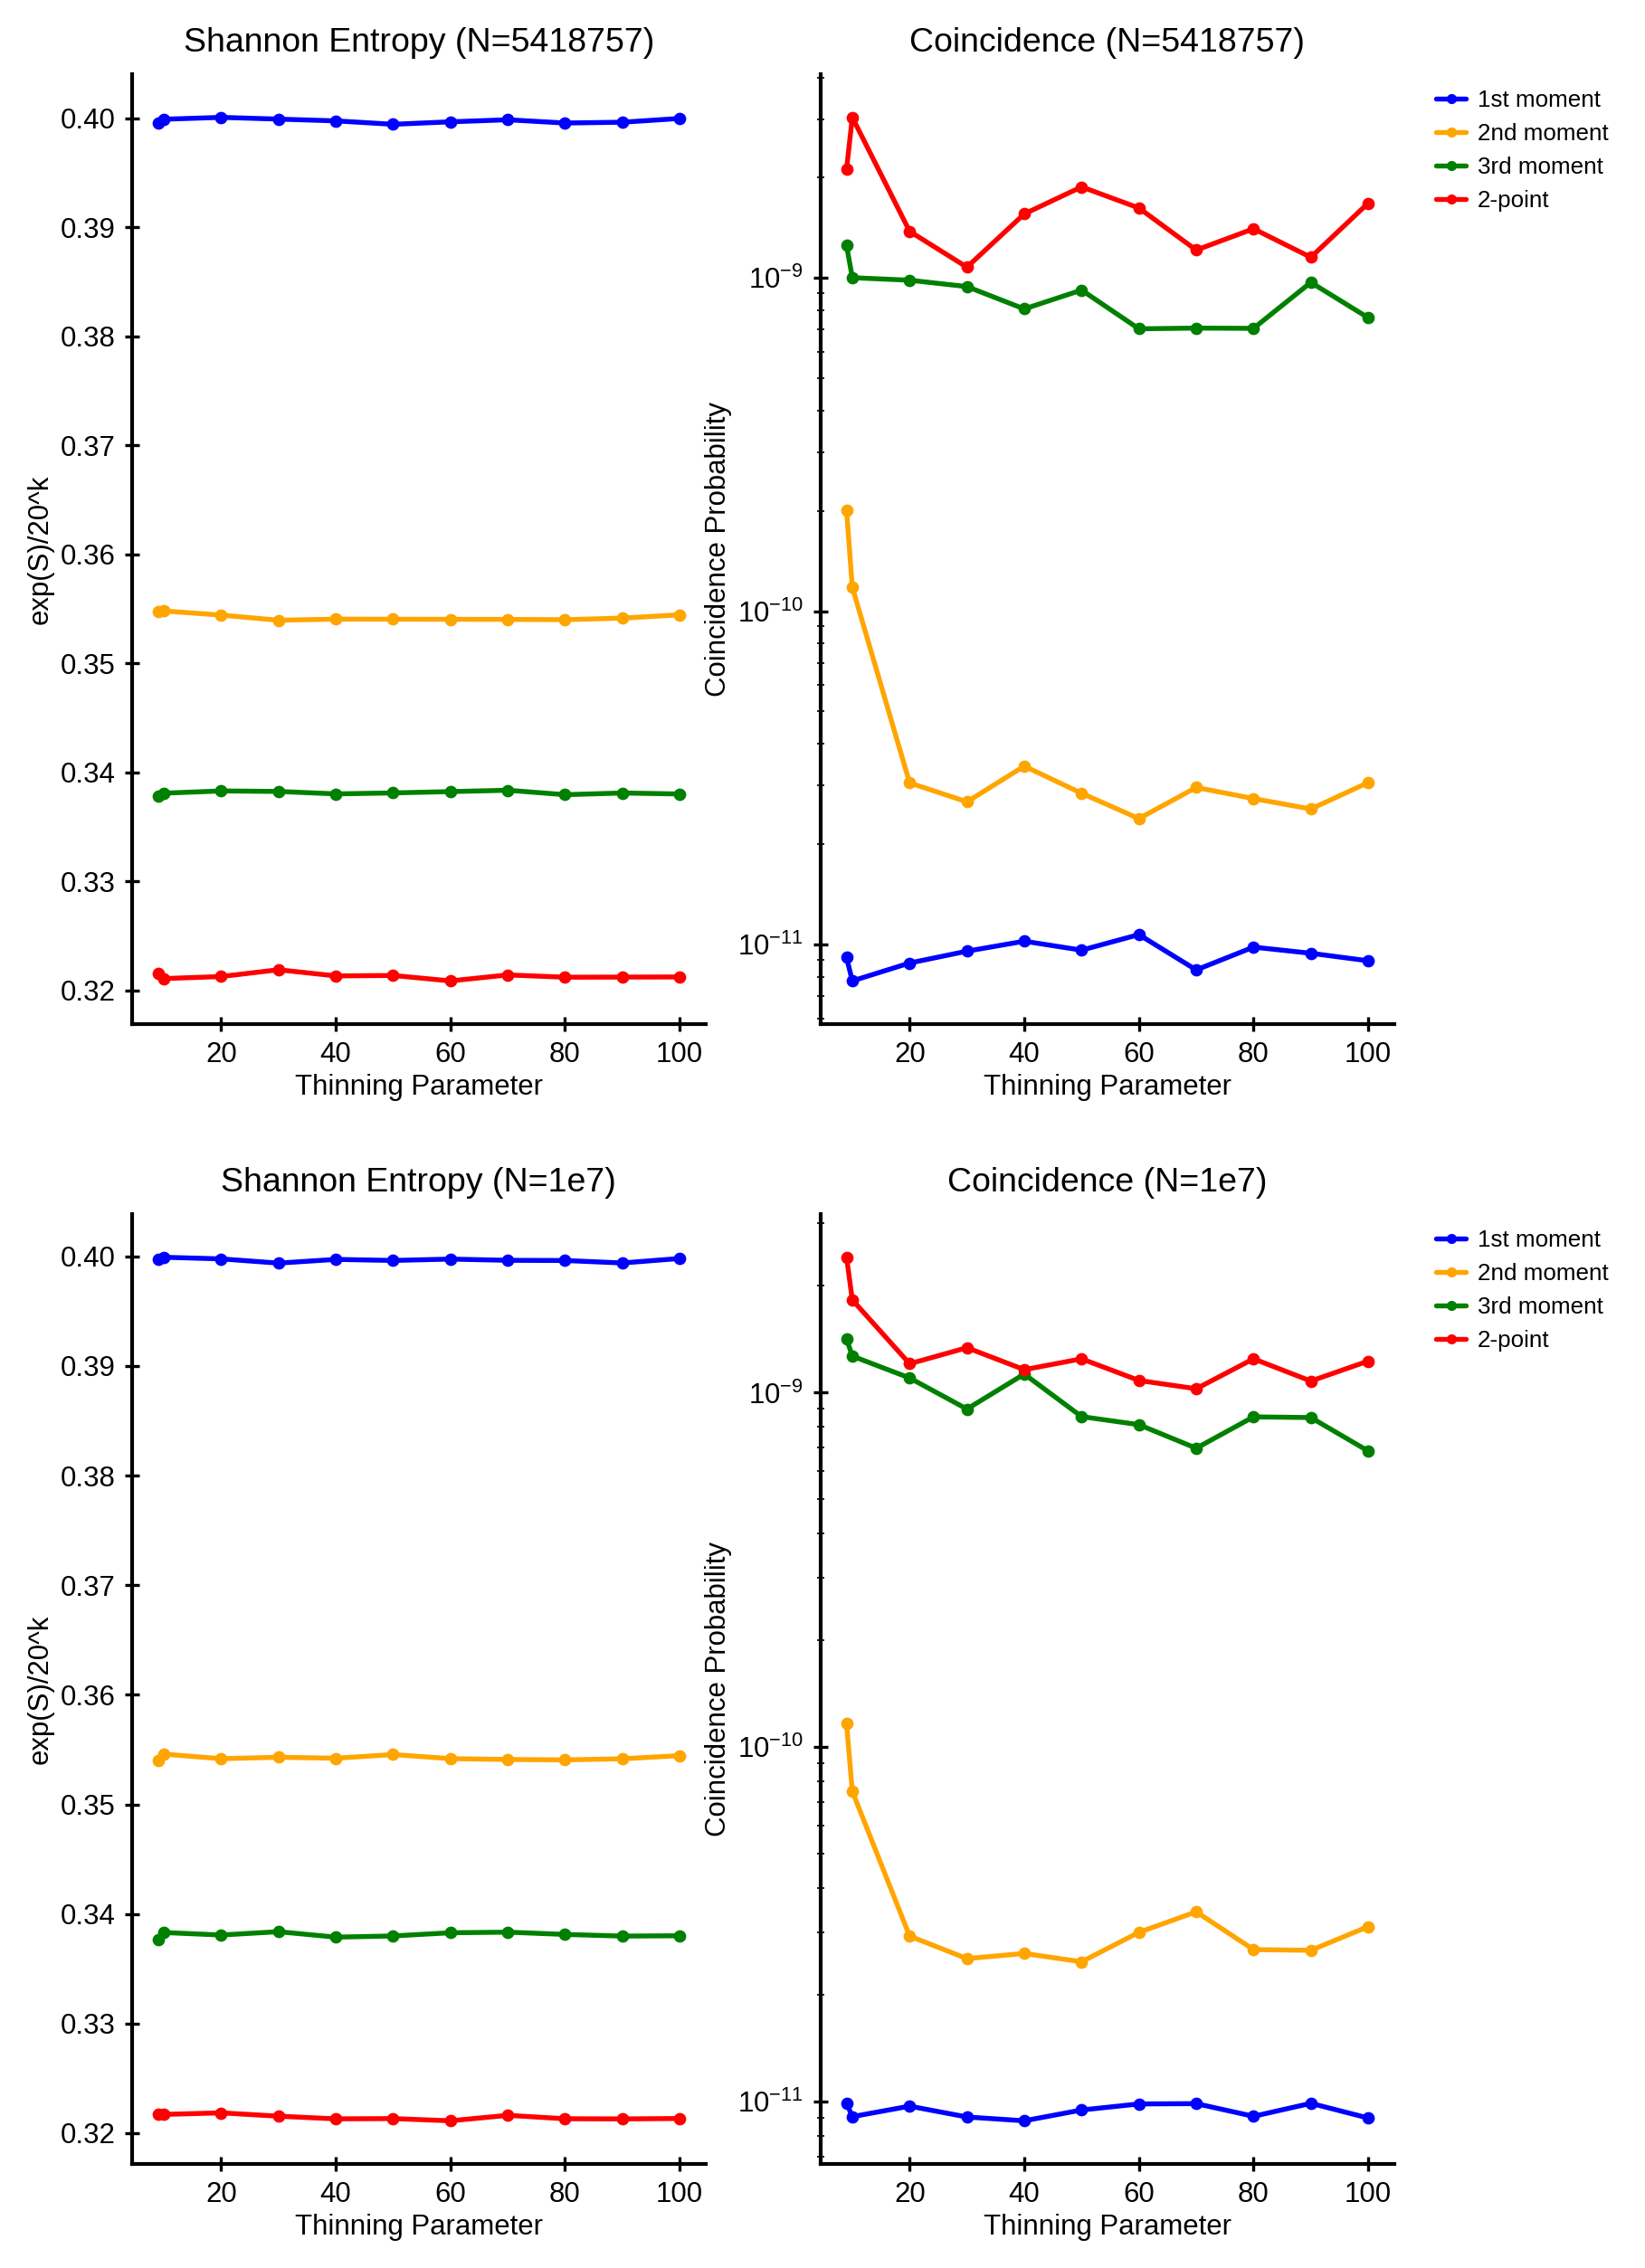

In [6]:
plt.figure(figsize=(6,10))
NSTEPS = ["5418757","1e7"]

plt.subplot(2,2,1)
for model in models:
    vals = list(s_data_small[model].values())
    
    plt.plot(s_data_small[model].keys(), np.exp(vals)/20**k, '-o', color=color_mapper[model], label=model_mapper[model])
plt.ylabel('exp(S)/20^k')
plt.xlabel('Thinning Parameter')
plt.title(f'Shannon Entropy (N={NSTEPS[0]})')

plt.subplot(2,2,2)
for model in models:
    vals = list(pc_data_small[model].values())
    
    plt.plot(pc_data_small[model].keys(), vals, '-o',color=color_mapper[model], label=model_mapper[model])
plt.yscale('log')
plt.ylabel('Coincidence Probability')
plt.xlabel('Thinning Parameter')
plt.title(f'Coincidence (N={NSTEPS[0]})')

plt.legend(loc='upper right',bbox_to_anchor=(1.4,1))

plt.subplot(2,2,3)
for model in models:
    vals = list(s_data_large[model].values())
    
    plt.plot(s_data_large[model].keys(), np.exp(vals)/20**k, '-o', color=color_mapper[model], label=model_mapper[model])
plt.ylabel('exp(S)/20^k')
plt.xlabel('Thinning Parameter')
plt.title(f'Shannon Entropy (N={NSTEPS[1]})')

plt.subplot(2,2,4)
for model in models:
    vals = list(pc_data_large[model].values())
    
    plt.plot(pc_data_large[model].keys(), vals, '-o',color=color_mapper[model], label=model_mapper[model])
plt.yscale('log')
plt.ylabel('Coincidence Probability')
plt.xlabel('Thinning Parameter')
plt.title(f'Coincidence (N={NSTEPS[1]})')

plt.legend(loc='upper right',bbox_to_anchor=(1.4,1))

plt.savefig('plots/extra_thinning_analysis.png')

In [ ]:
s_data_small[model].keys(), np.exp(vals)/20**k)


dict_keys([9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])

In [67]:
with open('data/human_model_thinning_analysis.json', 'w') as fp:
    json.dump(thinning_data, fp)

In [3]:
with open('data/human_model_thinning_analysis.json', 'r') as fp:
    thinning_data = json.load(fp)

## same analysis but for virus model

In [13]:
virus_data = {}

In [14]:
proteome = 'Humanviruses'
models = ['independent', 'ncov', 'nskew', 'nskewfcov']
k = 9

original_sampler = {
    'pc' : {},
    'S': {},
    'N': {},
    'energies': {}
}


for model in models:
    print(f'model: {model}')
    energy = make_energy(np.load(f'../maxent/data/{proteome}_{model}_k{k}_params.npz'))
    F = float(pd.read_csv(f'../maxent/data/{proteome}_{model}_k{k}_entropy.csv',header=None, index_col=0).loc['F'].values[0])
    
    loglikelihood  = lambda seq: -energy(seq) + F
    
    matrix = load_matrix(f'data/{proteome}_{model}_k{k}_matrix.csv.gz')

    original_sampler['N'][model] = matrix.shape[0]
    coincidence_empirical = calc_coincidence_prob(matrix)
    original_sampler['pc'][model] = compute_pc(matrix)
    logp = np.array([loglikelihood(row) for row in matrix])

    energies = [energy(x) for x in matrix]
    original_sampler['energies'][model] = energies
    original_sampler['S'][model] = np.mean(np.array(energies)) - F    

virus_data['original_sample'] = original_sampler

model: independent
model: ncov
model: nskew
model: nskewfcov


In [15]:
# Focus on human for now for comparisons
proteome = 'Humanviruses'
models = ['independent', 'ncov', 'nskew', 'nskewfcov']
# NSTEPS = ["5418757", "1e7", "5e7"]
NSTEPS = ["5418757", "1e7"]
thinning = ["9", "20", "50"]
k=9

for n in NSTEPS:
    for t in thinning:
        sampler = {
            'pc' : {},
            'S': {},
            'N': {},
            'energies': {},
        }
        for model in models:
            print(f'model: {model}')
            energy = make_energy(np.load(f'data/{proteome}_{model}_k{k}_params.npz'))
            F = float(pd.read_csv(f"data/mcmc_thermo/{proteome}_{model}_{n}_{t}_entropy.csv",header=None, index_col=0).loc['F'].values[0])
            
            loglikelihood  = lambda seq: -energy(seq) + F
            
            matrix = load_matrix(f"data/mcmc_thermo/{proteome}_{model}_{n}_{t}_matrix.csv.gz")
        
            sampler['N'][model] = matrix.shape[0]
            coincidence_empirical = calc_coincidence_prob(matrix)
            sampler['pc'][model] = compute_pc(matrix)
            logp = np.array([loglikelihood(row) for row in matrix])
        
            energies = [energy(x) for x in matrix]
            sampler['energies'][model] = energies
            sampler['S'][model] = np.mean(np.array(energies)) - F    

        virus_data[f"Humanviruses_{n}_{t}"] = sampler


model: independent
model: ncov
model: nskew
model: nskewfcov
model: independent
model: ncov
model: nskew
model: nskewfcov
model: independent
model: ncov
model: nskew
model: nskewfcov
model: independent
model: ncov
model: nskew
model: nskewfcov
model: independent
model: ncov
model: nskew
model: nskewfcov
model: independent
model: ncov
model: nskew
model: nskewfcov


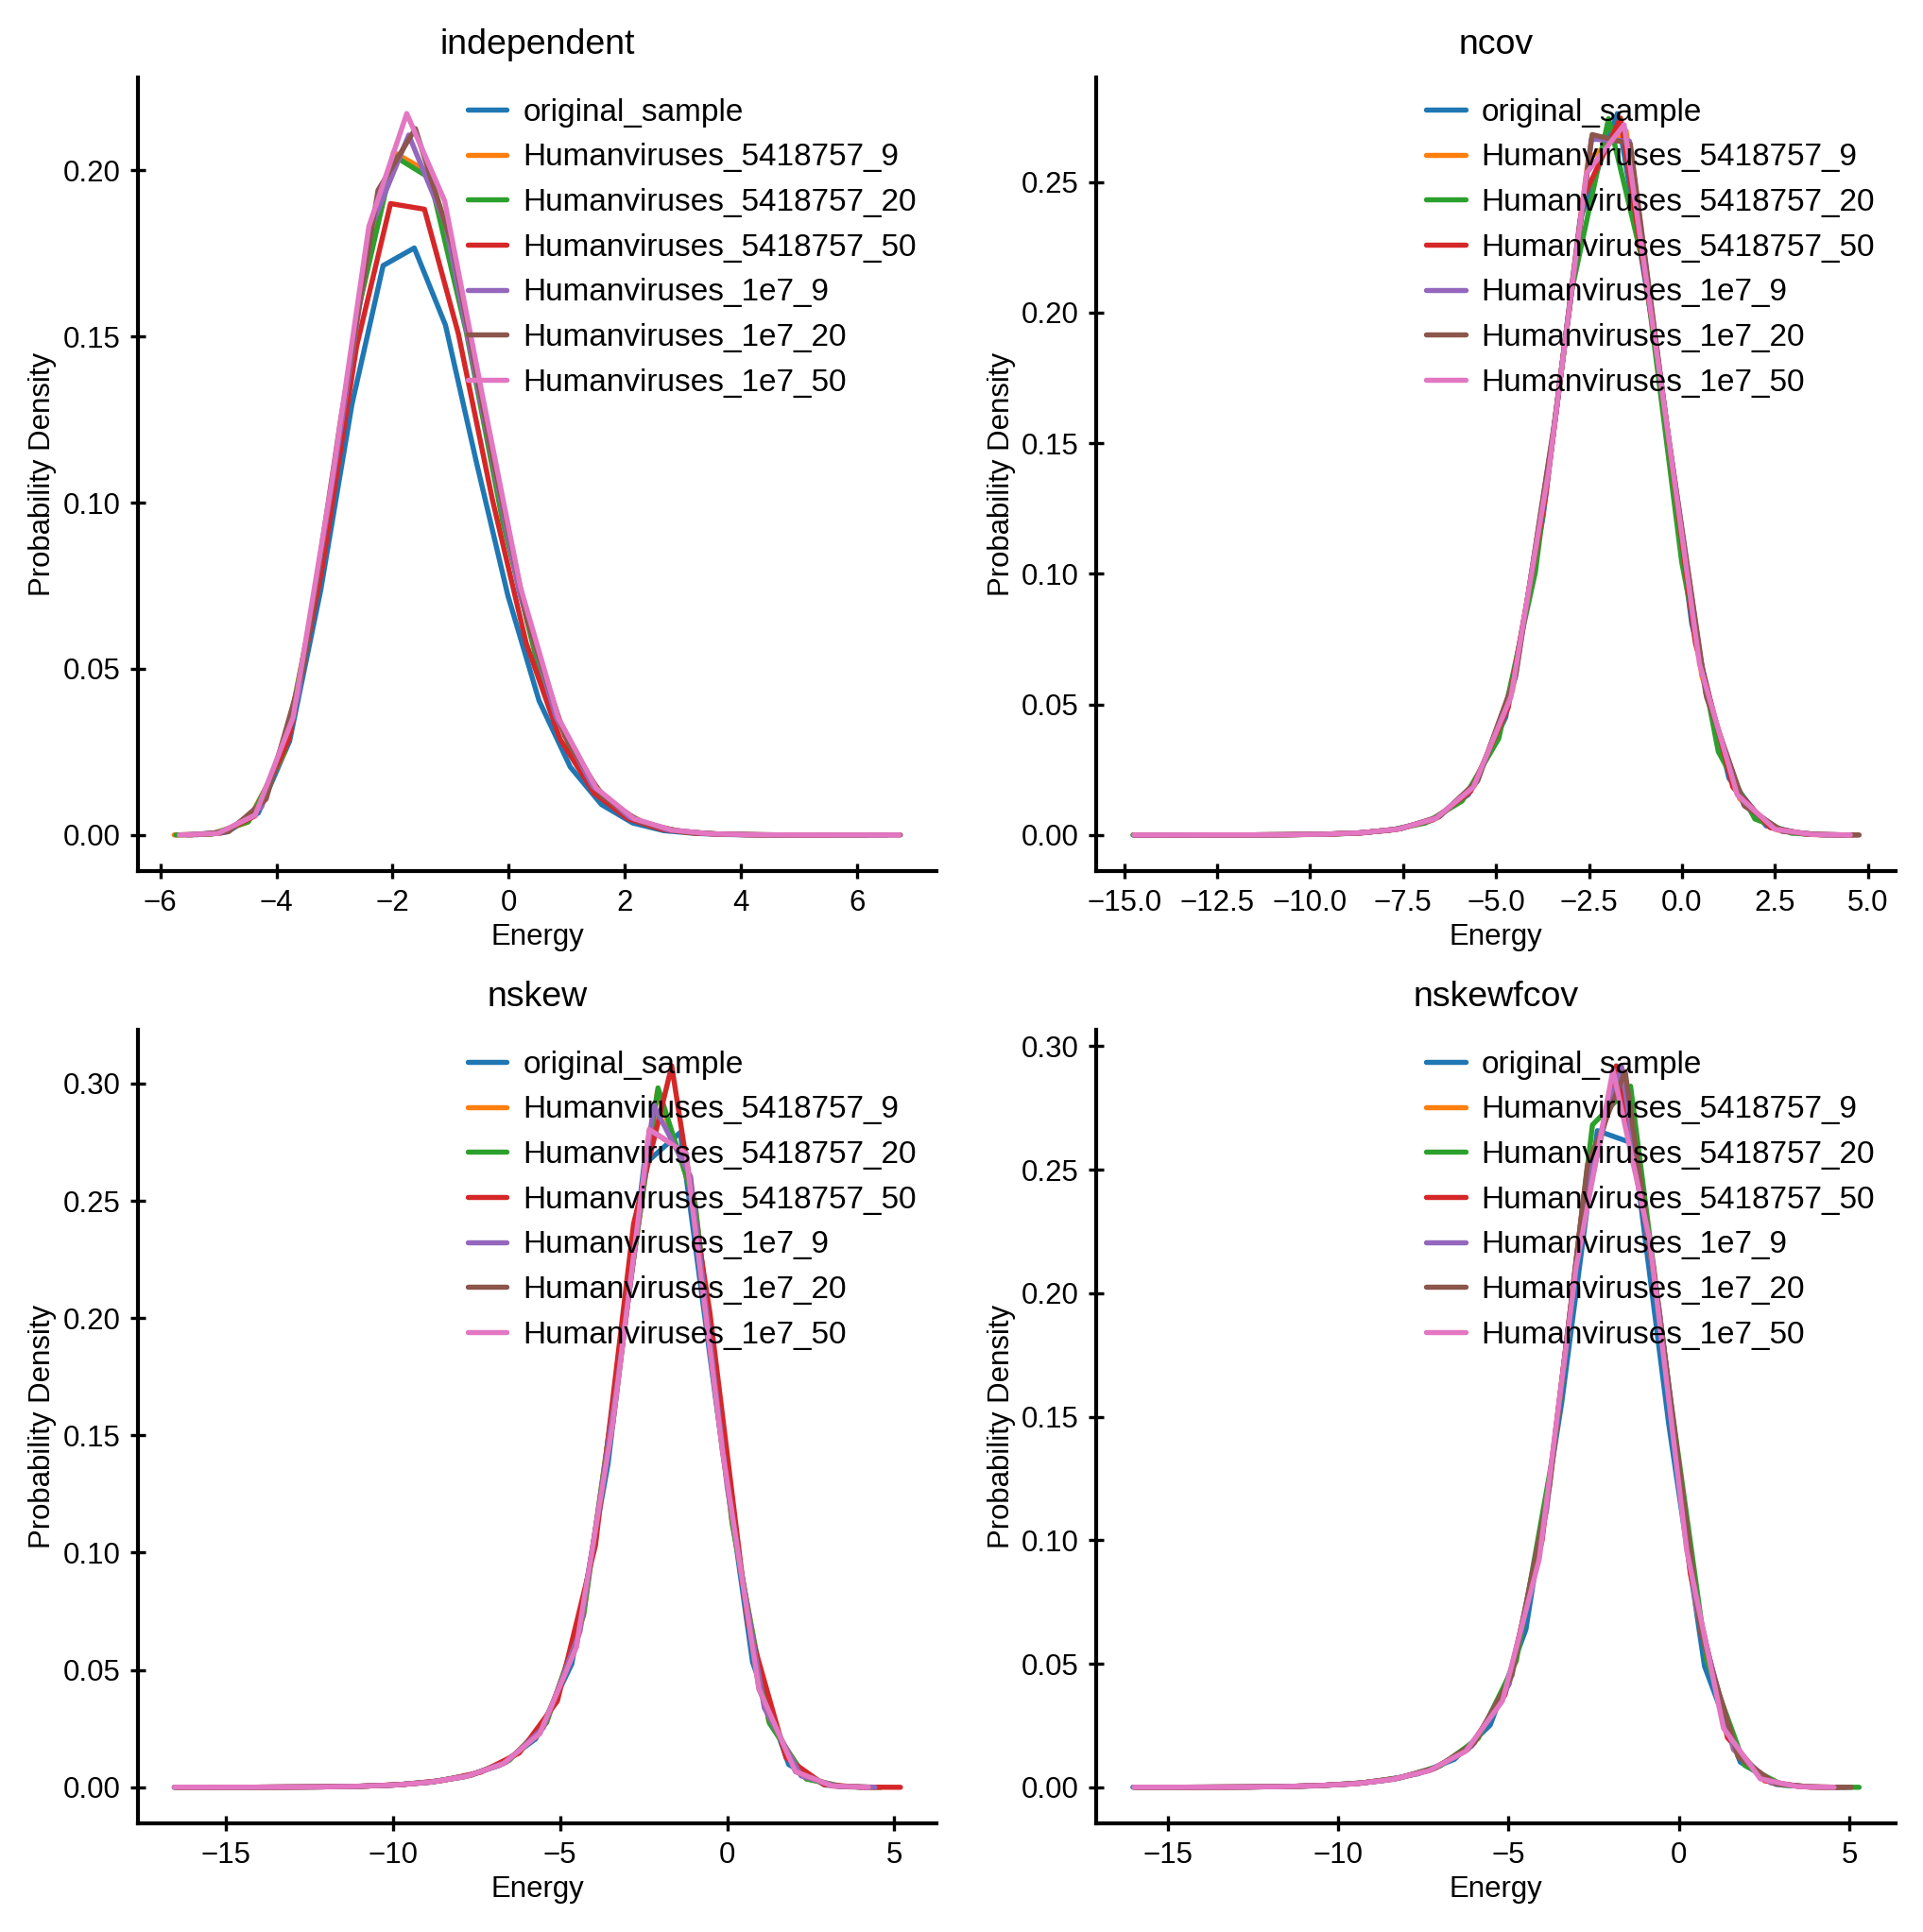

In [8]:
plt.figure(figsize=(8,8))
for i,model in enumerate(models):
    
    plt.subplot(2,2,i+1)
    for j, sampler in enumerate(virus_data):
        count, bins_count = np.histogram(virus_data[sampler]['energies'][model],bins=20)
        pdf = count / sum(count)
        plt.plot(bins_count[1:], pdf, label=sampler)
        plt.xlabel('Energy')
        plt.title(model)
        plt.ylabel('Probability Density')  
        plt.legend(loc='upper right',fontsize=8)

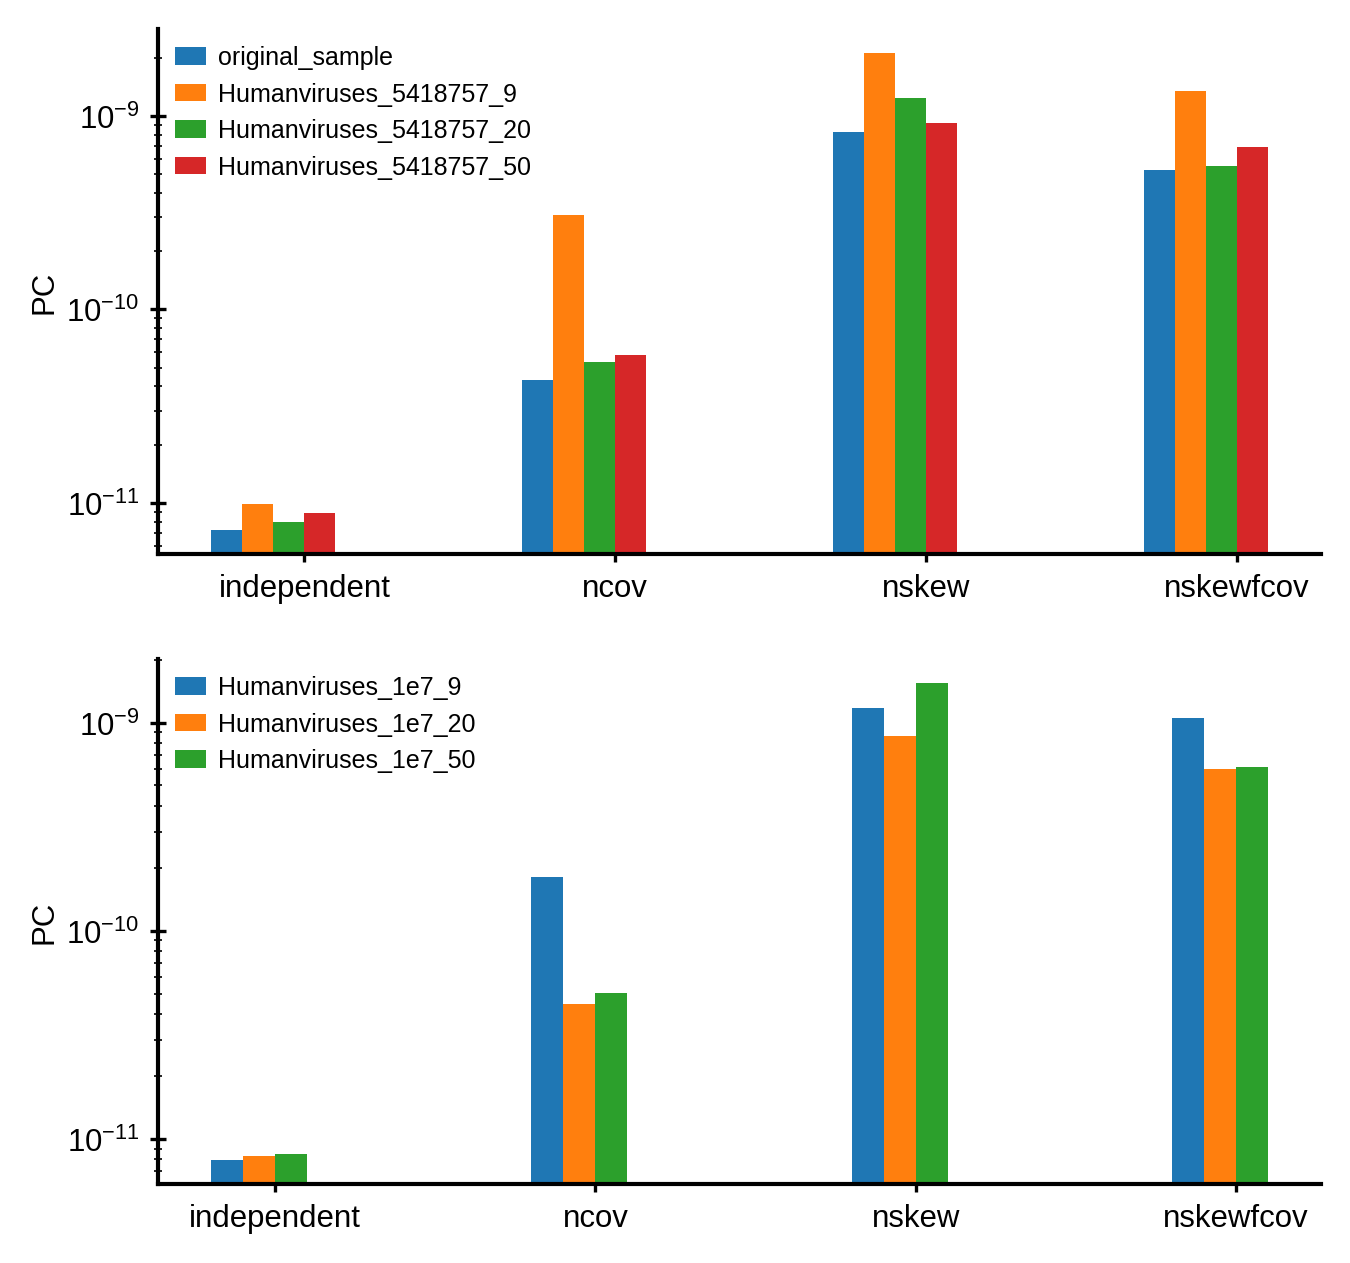

In [9]:
plt.figure(figsize=(5,5))

count = 0
for j, sampler in enumerate(virus_data):

    if j % 4 == 0:
        count += 1
        plt.subplot(2,1,count)
        

    bar_data = [virus_data[sampler]['pc'][model] for model in models]
    
    N = len(bar_data)
    ind = np.arange(N)
    width = 0.1  

    ind = ind + j*width
    plt.bar(ind + width, bar_data, width ,label=sampler)

    plt.yscale('log')

    plt.ylabel('PC')
    plt.xticks(ind + width / 2, models)
    plt.legend(fontsize=6)

plt.show()

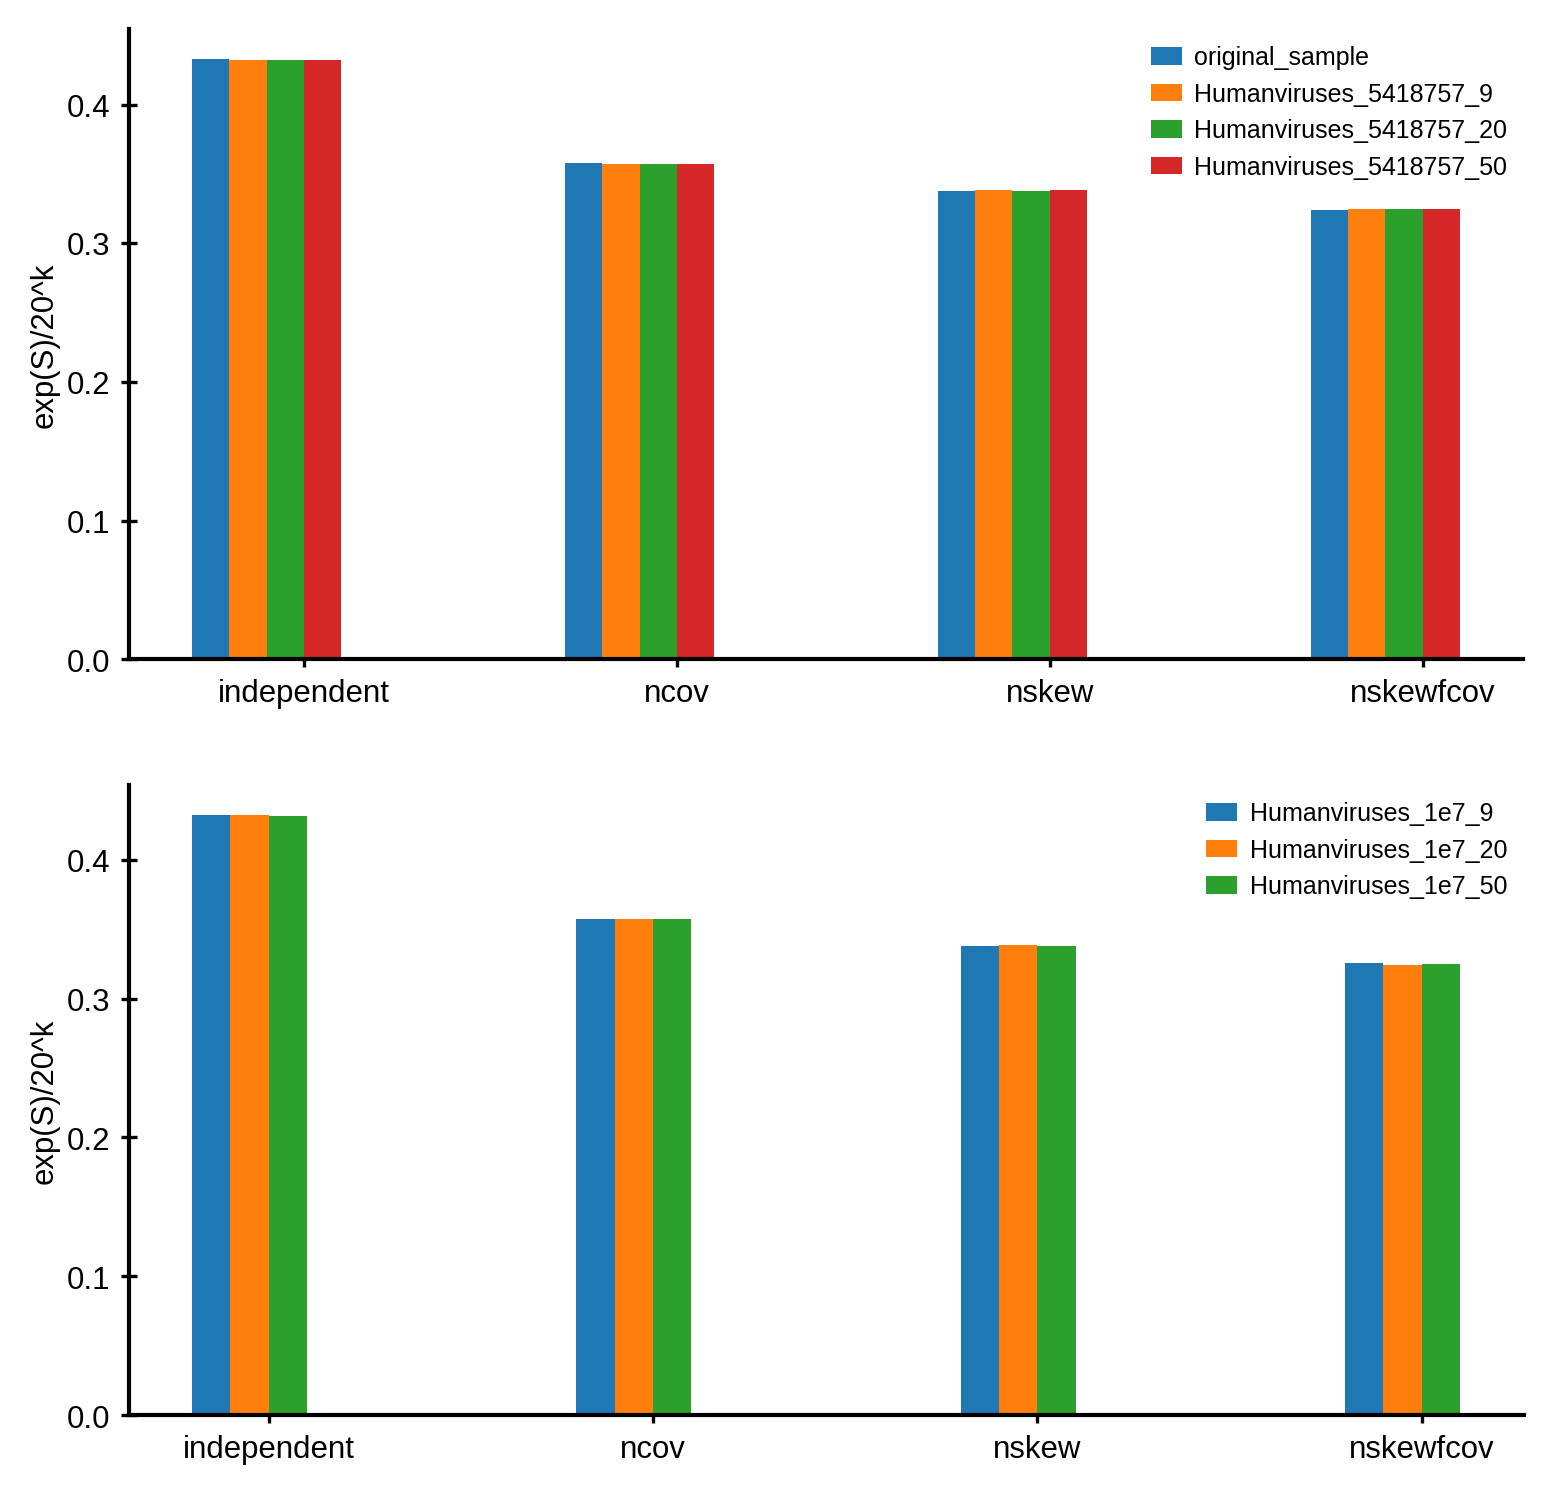

In [10]:
plt.figure(figsize=(6,6))

count = 0
for j, sampler in enumerate(virus_data):

    if j % 4 == 0:
        count += 1
        plt.subplot(2,1,count)
        

    bar_data = [np.exp(virus_data[sampler]['S'][model])/(20**9) for model in models]
    
    N = len(bar_data)
    ind = np.arange(N)
    width = 0.1  

    ind = ind + j*width
    plt.bar(ind + width, bar_data, width ,label=sampler)

    plt.ylabel('exp(S)/20^k')
    plt.xticks(ind + width / 2, models)
    plt.legend(fontsize=6, loc='upper right')

plt.show()

In [16]:
def get_mhc_df(model, allele):
    try:
        return pd.read_csv(f'data/netMHC_output/net_mhc_output_thermo_virus_{model}-{allele}.csv')
    except Exception as e:
        print(f'Missing CSV: {model},{allele}')
        return None
        
def get_combined_binders(model, alleles):

    kmers = set()
    for allele in alleles:
        print(allele)
        mhc_df = get_mhc_df(model, allele)
        if mhc_df is not None:
            try:
                kmers = kmers.union(set(mhc_df['Peptide']))
            except Exception as e:
                print(f'Messed up CSV: {model},{allele}')
                print(e)
    return kmers

In [23]:
with open('data/humanviruses_model_sampling_analysis.json', 'w') as fp:
    json.dump(virus_data, fp)